# Esfuerzos verticales totales y efectivos en un perfil de suelo estratificado

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

Este notebook se puede ejecutar interactivamente en [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/stress_vs_depth.ipynb).


## Required modules and global setup for plots

In [1]:
import ast # helps with converting str representation of python data structures
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from ipywidgets import widgets as wgt
from IPython import get_ipython
from IPython.display import display

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    run('pip install ipympl', shell=True);
    from google.colab import output
    output.enable_custom_widget_manager()

%matplotlib widget

plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)
html_setup = '<style> div.jupyter-widgets.widget-label {display: none;} </style>'

## Functions

In [2]:
def plot_stress_vs_depth(depths, γ_moist, γ_sat, wt_depth, γ_w, widget=False):
    if type(depths) == str:  # This is for interpreting in from the widget
        depths = ast.literal_eval(f"[{depths}]")
    if type(γ_moist) == str:  # This is for interpreting in from the widget
        γ_moist = ast.literal_eval(f"[{γ_moist}]")
    if type(γ_sat) == str:  # This is for interpreting in from the widget
        γ_sat = ast.literal_eval(f"[{γ_sat}]")
    # Find the index where the new value should be inserted
    min_idx = min(len(depths), len(γ_moist), len(γ_sat))
    depths_copy = depths[:min_idx].copy()
    γ_moist_copy = γ_moist[:min_idx].copy()
    γ_sat_copy = γ_sat[:min_idx].copy()
    # Find an appropiate index for locating the watertable
    if wt_depth >= depths[-1] or wt_depth is None:
        wt_depth = depths[-1]
        idx_wt = len(depths) - 1
    else:
        for i in range(len(depths)):
            if wt_depth <= depths[i]:
                idx_wt = i
                break
    # Insert the new value at the appropriate index
    depths_copy.insert(idx_wt, wt_depth)
    γ_moist_copy.insert(idx_wt, γ_moist[idx_wt])
    γ_sat_copy.insert(idx_wt, γ_sat[idx_wt])
    # Create an unified unit weight vector
    γ_s = γ_moist_copy[: idx_wt + 1] + γ_sat_copy[idx_wt + 1 :]
    # Create vector of thicknesses
    depths_copy.insert(0, 0)  # insert zero for the first layer
    thickness = np.diff(depths_copy)  # thickness of each soil layer [m]
    # Create a vector for unit weigth of water (zero above wt, and γ_w below)
    γ_w = np.full_like(thickness, γ_w)
    γ_w[: idx_wt + 1] = 0
    # Compute vertical stressess and water pressure at boundaries
    sigma_v = np.insert(np.cumsum(thickness * γ_s), 0, 0)
    p_w = np.insert(np.cumsum(thickness * γ_w), 0, 0)
    sigma_v_eff = sigma_v - p_w

    # Plot
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=[4, 4])
    for d in depths:
        ax.axhline(d, color="orange", ls="--")
    ax.plot(sigma_v, depths_copy, color="r", label="$\sigma_\mathrm{v}$")
    ax.plot(
        sigma_v_eff,
        depths_copy,
        ls="--",
        lw=1.2,
        color="k",
        label="$\sigma'_\mathrm{v}$",
    )
    ax.plot(
        p_w, depths_copy, ls="--", lw=1.2, color="b", label="$p_\mathrm{w}$"
    )
    ax.axhline(
        y=wt_depth, ls="-", color="dodgerblue", lw=1.2, label="Water\ntable"
    )
    ax.axhline(0, color="orange", ls="--", label="Layer\nboundary")
    # Plot setup
    ax.xaxis.set_label_position("top")
    ax.xaxis.tick_top()
    ax.invert_yaxis()
    ax.set(
        xlabel="$\sigma_\mathrm{v}$ -- $\sigma_\mathrm{v}'$ -- $p_\mathrm{w}$",
        ylabel="Depth, $z$",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["top"].set_linewidth(1.5)
    ax.grid(True, which="major", color="gray", linestyle="--")
    # fig.tight_layout()
    if widget:
        display(fig)
    else:
        plt.show()
        display(wgt.HTML(html_setup))
    plt.close()
    return


## Non-stratified profile

In [3]:
s, l = {'description_width': '50px'}, wgt.Layout(width='400px')
controls = {
    'depths': wgt.Text(value="10", description="z: ", style=s, layout=l),
    'γ_moist': wgt.Text(value="17", description="γ_moist: ", style=s, layout=l),
    'γ_sat': wgt.Text(value="21", description="γ_sat: ", style=s, layout=l),
    'wt_depth': wgt.FloatSlider(value=3, min=0, max=30, step=0.1, description='z_w', style=s, layout=l),
    'γ_w': wgt.BoundedFloatText(value=9.81, min=0, max=30, step=0.1, description='γ_w', style=s, layout=l),
    'widget': wgt.Checkbox(value=True, description='Non-vector image (improve widget performance)', disabled=False, style=s, layout=l)
}
fig = wgt.interactive_output(plot_stress_vs_depth, controls)
wgt.HBox((wgt.VBox(list(controls.values())), fig), layout=wgt.Layout(align_items='center'))

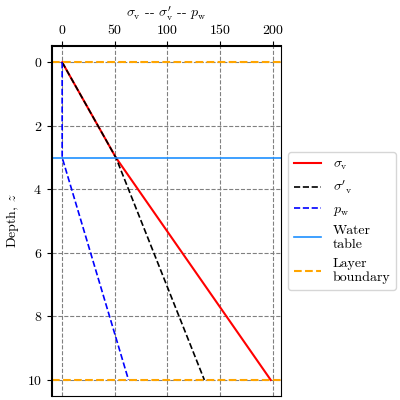

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [4]:
# Static figure
γ_moist = [17]  # Total/moist/bulk unit weight of each soil layer [kN/m³]
γ_sat = [21]  # Saturated unit weight of each soil layer [kN/m³]
depths = [10]  # bottom depth of each soil layer [m]
wt_depth = 3  # depth of the water table [m]
γ_w = 9.81  # unit weight of water [kN/m³]
plot_stress_vs_depth(depths, γ_moist, γ_sat, wt_depth, γ_w)

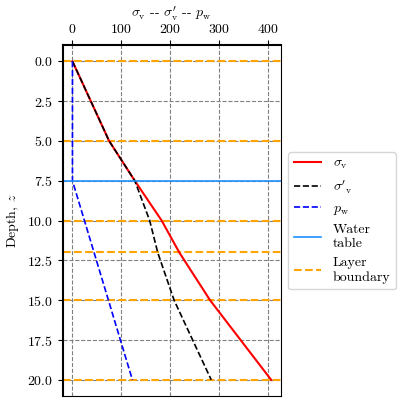

HTML(value='<style> div.jupyter-widgets.widget-label {display: none;} </style>')

In [5]:
# Static figure
depths = [5, 10, 12, 15, 20]  # bottom depth of each soil layer [m]
γ_moist = [15, 21, 17, 20, 24]  # Total/moist/bulk unit weight of each soil layer [kN/m³]
γ_sat = [16, 22, 18, 21, 25]  # Saturated unit weight of each soil layer [kN/m³]
wt_depth = 7.5  # depth of the water table [m]
γ_w = 9.81  # unit weight of water [kN/m³]
plot_stress_vs_depth(depths, γ_moist, γ_sat, wt_depth, γ_w)

## Stratified profile

In [6]:
s, l = {'description_width': '50px'}, wgt.Layout(width='400px')
controls = {
    'depths': wgt.Text(value="5, 10, 12, 15, 20", description="z: ", style=s, layout=l),
    'γ_moist': wgt.Text(value="15, 21, 17, 20, 24", description="γ_moist: ", style=s, layout=l),
    'γ_sat': wgt.Text(value="16, 22, 18, 21, 25", description="γ_sat: ", style=s, layout=l),
    'wt_depth': wgt.FloatSlider(value=3, min=0, max=30, step=0.1, description='z_w', style=s, layout=l),
    'γ_w': wgt.BoundedFloatText(value=9.81, min=0, max=30, step=0.1, description='γ_w', style=s, layout=l),
    'widget': wgt.Checkbox(value=True, description='Non-vector image (improve widget performance)', disabled=False, style=s, layout=l)
}
fig = wgt.interactive_output(plot_stress_vs_depth, controls)
wgt.HBox((wgt.VBox(list(controls.values())), fig), layout=wgt.Layout(align_items='center'))